In [30]:
import torch
import torchvision
import torch.utils.data
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import lr_scheduler
from torch import nn, optim

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

dataset = ImageFolder(
    '/media/akir/DATA/ml-data/dogs-vs-cats-redux-kernels-edition/data',
    transform
)

In [28]:
def show_batch(batch, fname=None):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))
    
    if fname:
        save_image(im, fname)

In [4]:
N_valid = 5000
N_test = 5000
N = len(dataset) - N_valid - N_test

train_data, valid_data, test_data = random_split(dataset, [N, N_valid, N_test])

In [5]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 1])


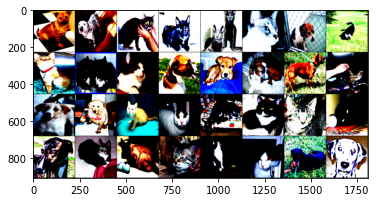

In [31]:
images, labels = next(iter(train_loader))
print(f'Labels: {labels}')
show_batch(images, 'images/cats-dogs.jpg')

In [7]:
def train(dataloader, model, optimizer, scheduler, criterion, device, n_epochs=50):

    model.train()

    for epoch in range(n_epochs):
        
        for i, batch in enumerate(dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()

            optimizer.step()
            scheduler.step()

        print(f'Epoch: {epoch}, loss: {loss}')


In [8]:
n_epochs = 3
lr = 0.01

model = torchvision.models.vgg11(pretrained=True)
for param in model.features:
    param.requires_grad = False
    
model.classifier[6] = nn.Linear(4096, 2)

model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

# One Cycle Policy scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    base_momentum=0.5,
    max_momentum=0.95,
    steps_per_epoch=len(train_loader),
    epochs=n_epochs,
)

criterion = nn.CrossEntropyLoss()

train(train_loader, model, optimizer, scheduler, criterion, device, n_epochs)

Epoch: 0, loss: 0.08094517141580582
Epoch: 1, loss: 0.002033839700743556
Epoch: 2, loss: 0.0004281600413378328


In [9]:
def evaluate(dataloader, model, device):

    model.eval()

    n_correct = 0.0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            X, y = batch
            
            X = X.to(device)
            y = y.to(device)

            y_hat = F.softmax(model(X), dim=1)
            y_pred = torch.argmax(y_hat, dim=1)

            n_correct += torch.sum(y_pred == y)
    
    accuracy = n_correct/len(dataloader.dataset)
    
    return accuracy

In [10]:
evaluate(valid_loader, model, device)

tensor(0.9898, device='cuda:0')

In [11]:
torch.save(model, 'cats-dogs-0.9894.pth')

/home/akir/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VGG. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akir/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akir/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akir/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0])


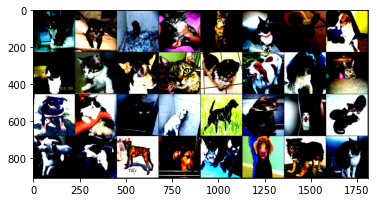

In [12]:
images, labels = next(iter(test_loader))
print(f'Labels: {labels}')
show_batch(images)

In [13]:
img = transform(Image.open('ostrich.jpg'))
pred = F.softmax(model(img.unsqueeze(0).to(device)), dim=1)
pred[0][0].item(), pred[0][1].item()

(0.9978234767913818, 0.0021765793208032846)

## MC Dropout

In [14]:
import torch
import torchvision
import torch.utils.data
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split
from torch.optim import lr_scheduler
from torch import nn, optim

from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

dataset = ImageFolder(
    '/media/akir/DATA/ml-data/dogs-vs-cats-redux-kernels-edition/data',
    transform
)

In [16]:
model = torch.load('cats-dogs-0.9894.pth')

In [17]:
def mc_predict_from_file(fpath, model, transform, device, T=1000):
    img = transform(Image.open(fpath))
    
    return mc_predict(img, model, transform, device, T)

In [18]:
def mc_predict(X, model, transform, device, T=1000):
    model.eval()
    y_hat = model(X.unsqueeze(0).to(device))
    y_pred = F.softmax(y_hat, dim=1)
    true_pred = torch.tensor([y_pred[0][0].item(), y_pred[0][1].item()])
    
    model.train()
    outputs = torch.zeros(T, 2).to(device)

    for i in range(T):
        y_hat = model(X.unsqueeze(0).to(device))
        y_pred = F.softmax(y_hat, dim=1)
        outputs[i] = torch.tensor([y_pred[0][0].item(), y_pred[0][1].item()])
    
    return true_pred, outputs

In [19]:
T = 1000
X = torch.randn(size=(3, 224, 224))
pred, mcs = mc_predict(X, model, transform, device, T)

In [45]:
T = 10
pred, mcs = mc_predict_from_file('ostrich.jpg', model, transform, device, T)
#pred, mcs = mc_predict_from_file('mercedes.jpg', model, transform, device, T)

In [46]:
pred

tensor([0.0767, 0.9233])

### Predictive entropy

In [47]:
# min = 0  when only a single class is sampled
# max = 0.5  when classes are sampled equally likely
-torch.sum(mcs.mean(axis=0)*torch.log(mcs.mean(axis=0))), pred

(tensor(0.3609, device='cuda:0'), tensor([0.0767, 0.9233]))

### Variation ratio

In [22]:
mode = torch.mode(mcs.argmax(axis=1))[0]
mode

tensor(1, device='cuda:0')

In [23]:
n_mode = torch.sum(mcs.argmax(axis=1) == mode)
n_mode

tensor(991, device='cuda:0')

In [24]:
# max = 0.5 when classes are sampled equally likely
# min = 0   when only a single class is sampled
variation_ratio = 1. - n_mode.type(torch.float)/T
variation_ratio, pred

(tensor(0.0090, device='cuda:0'), tensor([0.1236, 0.8764]))